# Selecting a GCM projection based on historical observations

In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
import tempfile
import datetime
from sklearn.svm import SVR
from natsort import natsorted
import geopandas as gpd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
import seaborn as sns
# import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
import os
import statsmodels.api as sm

In [2]:
# Plotting parameters

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 140

## Import data

In [3]:
# Average PRISM and Naselle gauge precipitation
gauge = pd.read_csv(config.daily_ppt.parents[0] / 'GHCND_USC00455774_1929_2020.csv', parse_dates=True, index_col=5)
gauge['SNOW'].fillna(0, inplace=True)
gauge['SNOW_SWE'] = gauge['SNOW'] / 13
gauge['PRCP_TOT'] = gauge['PRCP'] + gauge['SNOW_SWE']
gauge_precip = gauge[['PRCP_TOT']]

prism_precip = pd.read_csv(str(config.daily_ppt.parents[0] / 'prism_ppt_1981_2020_daily.csv'), parse_dates=True, index_col=0)

# Expand precip record to full date range in case some days are missing
hist_start = pd.to_datetime('01-01-1981')
hist_end = pd.to_datetime('12-31-2020')
rng = pd.date_range(hist_start, hist_end)
date_df = pd.DataFrame(index=rng)
gauge_precip_velma = date_df.merge(gauge_precip, left_index=True, right_index=True, how='left')
prism_precip_velma = date_df.merge(prism_precip, left_index=True, right_index=True, how='left')

prism_precip_mean = pd.concat([gauge_precip_velma, prism_precip_velma], axis=1)
prism_precip_mean['avg_precip'] = prism_precip_mean.mean(axis=1)
obs_p = prism_precip_mean.loc[:, ['avg_precip']]

# Air temperature
temp_path = config.daily_temp_mean.parents[0] / 'prism_temp_1981_2020_daily.csv'
obs_t = pd.read_csv(temp_path, parse_dates=True, index_col=0)

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\tnc_velma\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (9,13,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Get GCM precipitation 
wrf_dir = config.data_path / 'precip' / 'VIC_WRF_EllsworthCr'
gcm_avg_dir = wrf_dir / 'sim_avg'
cols = ['year', 'month', 'day', 'access1.0_RCP45', 'access1.0_RCP85', 'access1.3_RCP85',
        'bcc-csm1.1_RCP85', 'canesm2_RCP85', 'ccsm4_RCP85', 'csiro-mk3.6.0_RCP85',
        'fgoals-g2_RCP85', 'gfdl-cm3_RCP85', 'giss-e2-h_RCP85', 'miroc5_RCP85',
        'mri-cgcm3_RCP85', 'noresm1-m_RCP85']

arr = np.loadtxt(gcm_avg_dir / 'sim_avg_ppt.gz')
proj_sims_ppt = pd.DataFrame(data=arr, columns=cols)
proj_sims_ppt.index = pd.to_datetime(proj_sims_ppt[['year', 'month', 'day']])
proj_sims_ppt = proj_sims_ppt.drop(['year', 'month', 'day'], axis=1)
proj_sims_ppt_d = proj_sims_ppt.groupby(pd.Grouper(freq='d')).sum()

In [5]:
# Get temperature
forc_dir = config.data_path / 'precip' / 'WRF_frcs_EllsworthCr_forcings'
gcm_avg_forc_dir = forc_dir / 'sim_avg'
cols = ['year', 'month', 'day', 'access1.0_RCP45', 'access1.0_RCP85', 'access1.3_RCP85',
        'bcc-csm1.1_RCP85', 'canesm2_RCP85', 'ccsm4_RCP85', 'csiro-mk3.6.0_RCP85',
        'fgoals-g2_RCP85', 'gfdl-cm3_RCP85', 'giss-e2-h_RCP85', 'miroc5_RCP85',
        'mri-cgcm3_RCP85', 'noresm1-m_RCP85']

arr = np.loadtxt(gcm_avg_forc_dir / 'sim_avg_temp.gz')
proj_sims_temp = pd.DataFrame(data=arr, columns=cols)
proj_sims_temp.index = pd.to_datetime(proj_sims_temp[['year', 'month', 'day']])
proj_sims_temp = proj_sims_temp.drop(['year', 'month', 'day'], axis=1)
proj_sims_temp_d = proj_sims_temp.groupby(pd.Grouper(freq='d')).mean()

## Plotting

Text(0.5, 0, 'Year')

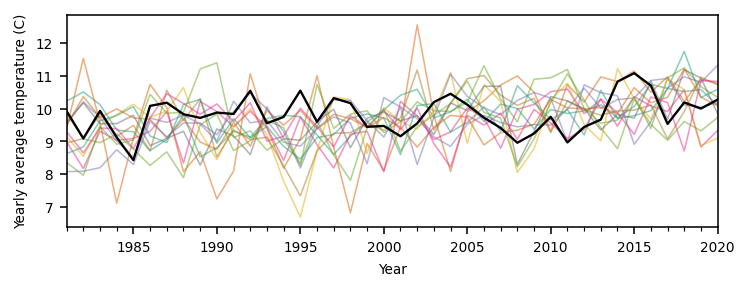

In [6]:
# Plot monthly and yearly average temps of all GCMs vs. historical
colors = sns.color_palette('Dark2', 13)
hist_start = pd.to_datetime('01-01-1981')
hist_end = pd.to_datetime('12-31-2020')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 2))
for i, sim in enumerate(proj_sims_temp):
    sim_data = proj_sims_temp_d.loc[:, sim]
    sim_subset = sim_data[(sim_data.index >= hist_start) & (sim_data.index <= hist_end)]
    sim_group = sim_subset.groupby(pd.Grouper(freq='y')).mean()
    sim_group.plot(label=sim, color=colors[i], alpha=0.5, ax=ax, linewidth=0.8)
obs_t.groupby(pd.Grouper(freq='y')).mean().plot(label='Observed (PRISM)', color='black', linewidth=1.2, ax=ax)
ax.get_legend().remove()
ax.set_ylabel('Yearly average temperature (C)')
ax.set_xlabel('Year')
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [7]:
sim_subset = proj_sims_temp_d[(proj_sims_temp_d.index >= hist_start) & (proj_sims_temp_d.index <= hist_end)]
np.abs(sim_subset.groupby(pd.Grouper(freq='y')).mean().sub(obs_t['temp'], axis=0)).sum(axis=0)

access1.0_RCP45        244.685423
access1.0_RCP85        240.909473
access1.3_RCP85        241.146225
bcc-csm1.1_RCP85       234.109330
canesm2_RCP85          242.554440
ccsm4_RCP85            242.046603
csiro-mk3.6.0_RCP85    244.131986
fgoals-g2_RCP85        240.210223
gfdl-cm3_RCP85         242.113721
giss-e2-h_RCP85        242.058648
miroc5_RCP85           242.635993
mri-cgcm3_RCP85        237.612569
noresm1-m_RCP85        233.282778
dtype: float64

Text(0.5, 0, 'Year')

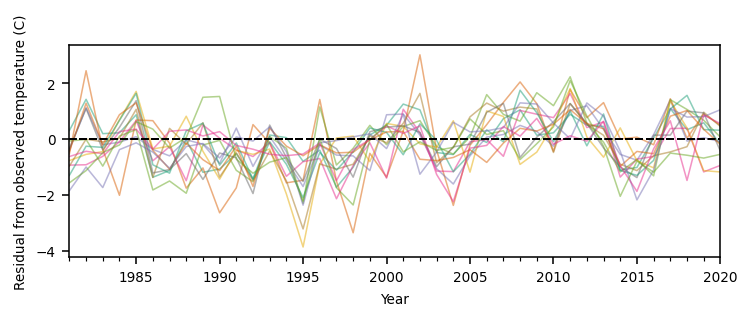

In [8]:
plt.close('all')
# Plot residuals from observed temp
colors = sns.color_palette('Dark2', 13)
hist_start = pd.to_datetime('01-01-1981')
hist_end = pd.to_datetime('12-31-2020')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 2))

obs = obs_t.groupby(pd.Grouper(freq='y')).mean()
for i, sim in enumerate(proj_sims_temp_d):
    sim_data = proj_sims_temp_d.loc[:, sim]
    sim_subset = sim_data[(sim_data.index >= hist_start) & (sim_data.index <= hist_end)]
    sim_group = sim_subset.groupby(pd.Grouper(freq='y')).mean()
    sim_resid = sim_group - obs.iloc[:,0]
    sim_resid.plot(label=sim, color=colors[i], alpha=0.5, ax=ax, linewidth=0.8)
    ax.axline((11, 0), slope=0, linewidth=1, color='black', linestyle='--')
ax.set_ylabel('Residual from observed temperature (C)')
ax.set_xlabel('Year')


<AxesSubplot:>

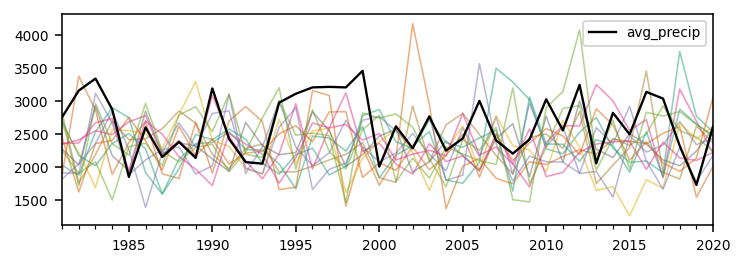

In [9]:
# Plot monthly and yearly total precip of all GCMs vs. historical
colors = sns.color_palette('Dark2', 13)
hist_start = pd.to_datetime('01-01-1981')
hist_end = pd.to_datetime('12-31-2020')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 2))
for i, sim in enumerate(proj_sims_ppt_d):
    sim_data = proj_sims_ppt_d.loc[:, sim]
    sim_subset = sim_data[(sim_data.index >= hist_start) & (sim_data.index <= hist_end)]
    sim_group = sim_subset.groupby(pd.Grouper(freq='y')).sum()
    sim_group.plot(label=sim, color=colors[i], alpha=0.5, ax=ax, linewidth=0.8)
#     ax.get_legend().remove()
obs_p.groupby(pd.Grouper(freq='y')).sum().plot(label='Observed (PRISM)', color='black', linewidth=1.2, ax=ax)

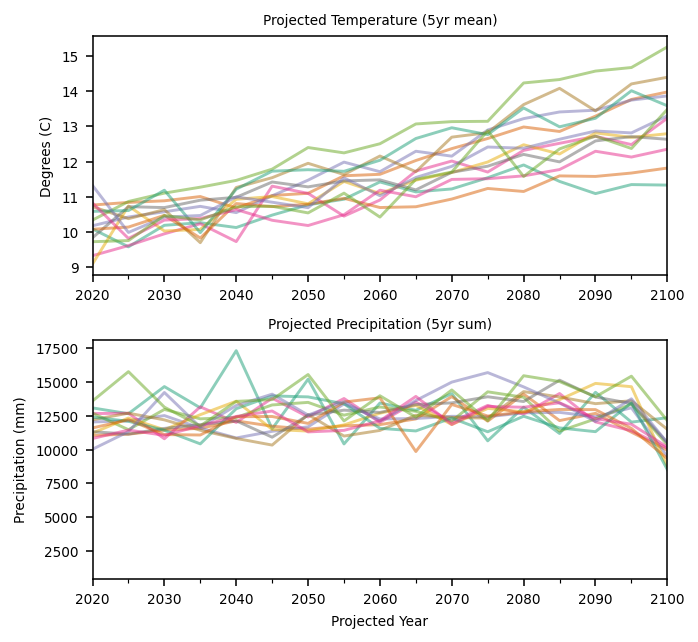

In [11]:
# Plot projected average temps of all GCMs
plt.close('all')
colors = sns.color_palette('Dark2', 13)
proj_start = pd.to_datetime('01-01-2020')
proj_end = pd.to_datetime('12-31-2099')
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 5))
for i, sim in enumerate(proj_sims_temp):
    sim_data = proj_sims_temp_d.loc[:, sim]
    sim_subset = sim_data[(sim_data.index >= proj_start) & (sim_data.index <= proj_end)]
    sim_group = sim_subset.groupby(pd.Grouper(freq='5y')).mean()
    sim_group.plot(label=sim, color=colors[i], alpha=0.5, ax=axes[0])
    
    sim_data = proj_sims_ppt_d.loc[:, sim]
    sim_subset = sim_data[(sim_data.index >= pd.to_datetime(str(proj_start.year-5))) & (sim_data.index <= proj_end)]
    sim_group = sim_subset.groupby(pd.Grouper(freq='5y')).sum()
    sim_group.plot(label=sim, color=colors[i], alpha=0.5, ax=axes[1])
    axes[1].set_xlim(('2020', '2100'))
    
axes[0].set_ylabel('Degrees (C)')
axes[0].set_title('Projected Temperature (5yr mean)')

axes[1].set_ylabel('Precipitation (mm)')
axes[1].set_xlabel('Projected Year')
axes[1].set_title('Projected Precipitation (5yr sum)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Calculate historical metrics of GCMs

Using some metrics from Rupp et al. (2013)

Nino indices from NOAA https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/

A little unclear on how precipitation is supposed to be calculated for some of these. Trend precip doesn't quite match Rupp et al., they use % change from the 100 year mean, but doing that gives really small values.

https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2Fjgrd.50843&file=ReadMe.txt

This uses monthly mean precip for most calculations, as Rupp does

In [18]:
hist_start = pd.to_datetime('01-01-1981')
hist_end = pd.to_datetime('12-31-2020')
proj_temp_sub = proj_sims_temp_d[(proj_sims_temp_d.index >= hist_start) & (proj_sims_temp_d.index <= hist_end)]
proj_ppt_sub = proj_sims_ppt_d[(proj_sims_ppt_d.index >= hist_start) & (proj_sims_ppt_d.index <= hist_end)]


# Get monthly means
monthly_t = proj_temp_sub.groupby(pd.Grouper(freq='m')).mean()
monthly_obs_t = obs_t.groupby(pd.Grouper(freq='m')).mean()
monthly_p = proj_ppt_sub.groupby(pd.Grouper(freq='m')).mean()
monthly_obs_p = obs_p.groupby(pd.Grouper(freq='m')).mean()


# Yearly mean temp/precip
mean_t = monthly_t.groupby(pd.Grouper(freq='y')).mean().mean(axis=0)  # deg C
mean_obs_t = monthly_obs_t.groupby(pd.Grouper(freq='y')).mean().mean(axis=0)
mean_p = monthly_p.groupby(pd.Grouper(freq='y')).sum().mean(axis=0)  # mm/yr
mean_obs_p = monthly_obs_p.groupby(pd.Grouper(freq='y')).sum().mean(axis=0)


# Correlation with observed monthly temp/precip
mat_t = monthly_t.copy()
mat_t['obs'] = monthly_obs_t
corr_t = mat_t.corr().iloc[:-1, -1]

mat_p = monthly_p.copy()
mat_p['obs'] = monthly_obs_p
corr_p = mat_p.corr().iloc[:-1, -1]

In [19]:
# Mean amplitude of seasonal cycle (warmest-coldest month, wettest-driest month, where monthly precip is % of mean annual total)
seasonal_amp_t = monthly_t.groupby(pd.Grouper(freq='y')).max() - monthly_t.groupby(pd.Grouper(freq='y')).min()   # deg C
seasonal_amp_t = seasonal_amp_t.mean(axis=0)
seasonal_amp_obs_t = monthly_obs_t.groupby(pd.Grouper(freq='y')).max() - monthly_obs_t.groupby(pd.Grouper(freq='y')).min()   # deg C
seasonal_amp_obs_t = seasonal_amp_obs_t.mean(axis=0)

z = proj_ppt_sub.groupby(pd.Grouper(freq='y')).sum()
x = np.repeat(np.array(z), repeats=12, axis=0)
yearly_tots_p = pd.DataFrame(x)
monthly_p_sum = proj_ppt_sub.groupby(pd.Grouper(freq='m')).sum()
monthly_perc_p = pd.DataFrame(monthly_p_sum.values /yearly_tots_p.values, columns=monthly_p.columns, index=monthly_p.index)
seasonal_amp_p = monthly_perc_p.groupby(pd.Grouper(freq='y')).max() - monthly_perc_p.groupby(pd.Grouper(freq='y')).min()
seasonal_amp_p = seasonal_amp_p.mean(axis=0)

z = obs_p.groupby(pd.Grouper(freq='y')).sum()
x = np.repeat(np.array(z), repeats=12, axis=0)
yearly_tots_obs_p = pd.DataFrame(x)
monthly_obs_p_sum = obs_p.groupby(pd.Grouper(freq='m')).sum()
monthly_perc_obs_p = pd.DataFrame(monthly_obs_p_sum.values / yearly_tots_obs_p.values, 
                                  columns=monthly_obs_p.columns, index=monthly_obs_p.index)
seasonal_amp_obs_p = monthly_perc_obs_p.groupby(pd.Grouper(freq='y')).max() - monthly_perc_obs_p.groupby(pd.Grouper(freq='y')).min()
seasonal_amp_obs_p = seasonal_amp_obs_p.mean(axis=0)

In [20]:
# Linear trend of annual temp
trend_t = np.polyfit(x=monthly_t.groupby(pd.Grouper(freq='y')).mean().index.year, 
                     y=monthly_t.groupby(pd.Grouper(freq='y')).mean(), deg=1)[0, :]  # deg/time period (1981-2020)

trend_obs_t = np.polyfit(x=monthly_obs_t.groupby(pd.Grouper(freq='y')).mean().index.year, 
                         y=monthly_obs_t.groupby(pd.Grouper(freq='y')).mean(), deg=1)[0, :]

# Linear trend of annual precip, calculated as % change from period mean

trend_p = np.polyfit(x=monthly_p.groupby(pd.Grouper(freq='y')).mean().index.year, 
                     y=monthly_p.groupby(pd.Grouper(freq='y')).mean(), deg=1)[0, :] # mm/time period (1981-2020)

trend_obs_p = np.polyfit(x=monthly_obs_p.groupby(pd.Grouper(freq='y')).mean().index.year, 
                         y=monthly_obs_p.groupby(pd.Grouper(freq='y')).mean(), deg=1)[0, :]

In [21]:
# Variance of temp calculated at aggregation periods from N=1 to N=8 years
freqs_t = ['1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y']
vars_t = [(monthly_t.groupby(pd.Grouper(freq=freq)).var()).mean(axis=0) for freq in freqs_t]

vars_obs_t = [(monthly_obs_t.groupby(pd.Grouper(freq=freq)).var()).mean(axis=0) for freq in freqs_t]


# Coefficient of variation of precip calculated at aggregation periods from N=1 to N=8 water years (Oct to Sep)
freqs_p = ['A-SEP', '2A-SEP', '3A-SEP', '4A-SEP', '5A-SEP', '6A-SEP', '7A-SEP', '8A-SEP']
cvs_p = [(monthly_p.groupby(pd.Grouper(freq=freq)).std() / 
          monthly_p.groupby(pd.Grouper(freq=freq)).mean()).mean(axis=0) for freq in freqs_p]

cvs_obs_p = [(monthly_obs_p.groupby(pd.Grouper(freq=freq)).std() / 
              monthly_obs_p.groupby(pd.Grouper(freq=freq)).mean()).mean(axis=0) for freq in freqs_p]

In [22]:
# Correlation of winter temp/precip with Nino3.4 index
nino = pd.read_table(config.data_path / 'precip' / 'sstoi.indices.txt', delim_whitespace=True, parse_dates={'date': ['YR', 'MON']}, index_col=0)
nino_sub = nino[(nino.index >= monthly_t.index.min()) & (nino.index <= monthly_t.index.max())]
nino_winter = nino_sub[~~nino_sub.index.month.isin([11, 12, 1, 2, 3])]
nino_winter = nino_winter.groupby(pd.Grouper(freq='y')).mean()

winter_t = proj_sims_temp_d.groupby(pd.Grouper(freq='AS-MAR')).mean()
winter_p = proj_sims_ppt_d.groupby(pd.Grouper(freq='AS-MAR')).sum()
winter_t_obs = obs_t.groupby(pd.Grouper(freq='AS-MAR')).mean()
winter_p_obs = obs_p.groupby(pd.Grouper(freq='AS-MAR')).sum()

winter_t = monthly_t[(monthly_t.index >= nino_sub.index.min()) & (monthly_t.index <= nino_sub.index.max())]
winter_t = winter_t[~~winter_t.index.month.isin([1, 2, 3])]
winter_t = winter_t.groupby(pd.Grouper(freq='y')).mean()
winter_t['nino'] = nino_winter['NINO3.4'].values
corr_nino_t = winter_t.corr()['nino'].drop('nino')

winter_obs_t = obs_t[(obs_t.index >= nino_sub.index.min()) & (obs_t.index <= nino_sub.index.max())]
winter_obs_t = winter_obs_t[~~winter_obs_t.index.month.isin([1, 2, 3])]
winter_obs_t = winter_obs_t.groupby(pd.Grouper(freq='y')).mean()
winter_obs_t['nino'] = nino_winter['NINO3.4'].values
corr_nino_obs_t = winter_obs_t.corr()['nino'].drop('nino')

winter_p = proj_sims_ppt_d[(proj_sims_ppt_d.index >= nino_sub.index.min()) & (proj_sims_ppt_d.index <= nino_sub.index.max())]
winter_p = winter_p[~~winter_p.index.month.isin([1, 2, 3])]
winter_p = winter_p.groupby(pd.Grouper(freq='y')).mean()
winter_p['nino'] = nino_winter['NINO3.4'].values
corr_nino_p = winter_p.corr()['nino'].drop('nino')

winter_obs_p = obs_p[(obs_p.index >= nino_sub.index.min()) & (obs_p.index <= nino_sub.index.max())]
winter_obs_p = winter_obs_p[~~winter_obs_p.index.month.isin([1, 2, 3])]
winter_obs_p = winter_obs_p.groupby(pd.Grouper(freq='y')).mean()
winter_obs_p['nino'] = nino_winter['NINO3.4'].values
corr_nino_obs_p = winter_obs_p.corr()['nino'].drop('nino')

## Compare historical metrics of GCMS

In [23]:
# Combine obs metrics
obs_metrics = [mean_obs_t.values, mean_obs_p.values, seasonal_amp_obs_t.values, seasonal_amp_obs_p.values, 
               trend_obs_t, trend_obs_p, corr_nino_obs_t.values, corr_nino_obs_p.values] #, vars_obs_t, vars_obs_p]
obs_metrics = obs_metrics + [x.values for x in vars_obs_t]
obs_metrics = obs_metrics + [x.values for x in cvs_obs_p]
obs_metrics_df = pd.DataFrame(data=np.column_stack(obs_metrics), 
                              columns=['mean_t', 'mean_p', 'seasonal_amp_t', 'seasonal_amp_p', 'trend_t', 'trend_p', 'nino_t', 'nino_p',
                                       'var_t_1yr', 'var_t_2yr', 'var_t_3yr', 'var_t_4yr', 'var_t_5yr', 'var_t_6yr', 'var_t_7yr', 'var_t_8yr',
                                       'cv_p_1yr', 'cv_p_2yr', 'cv_p_3yr', 'cv_p_4yr', 'cv_p_5yr', 'cv_p_6yr', 'cv_p_7yr', 'cv_p_8yr'], index=['obs'])


In [24]:
# Combine GCM metrics
metrics = [mean_t.values, mean_p.values, seasonal_amp_t.values, seasonal_amp_p.values, trend_t, trend_p, corr_nino_t.values, corr_nino_p.values]
metrics = metrics + [x.values for x in vars_t]
metrics = metrics + [x.values for x in cvs_p]
metrics_df = pd.DataFrame(data=np.column_stack(metrics), 
                          columns=['mean_t', 'mean_p', 'seasonal_amp_t', 'seasonal_amp_p', 'trend_t', 'trend_p', 'nino_t', 'nino_p',
                                   'var_t_1yr', 'var_t_2yr', 'var_t_3yr', 'var_t_4yr', 'var_t_5yr', 'var_t_6yr', 'var_t_7yr', 'var_t_8yr',
                                   'cv_p_1yr', 'cv_p_2yr', 'cv_p_3yr', 'cv_p_4yr', 'cv_p_5yr', 'cv_p_6yr', 'cv_p_7yr', 'cv_p_8yr'], 
                          index=mean_t.index)

metrics_df[['bias_t', 'bias_p']] = metrics_df[['mean_t', 'mean_p']] - obs_metrics_df[['mean_t', 'mean_p']].values
obs_metrics_df['bias_t'] = 0
obs_metrics_df['bias_p'] = 0

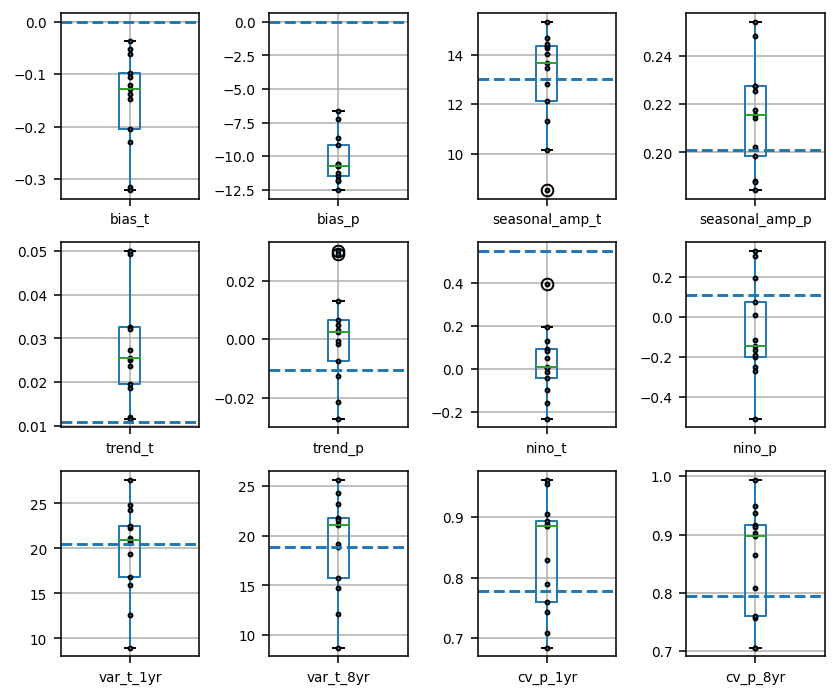

In [25]:
cols = ['bias_t', 'bias_p', 'seasonal_amp_t', 'seasonal_amp_p', 'trend_t', 'trend_p', 'nino_t', 'nino_p',
        'var_t_1yr',  'var_t_8yr', 'cv_p_1yr', 'cv_p_8yr'] 

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(6, 5))

for i, col in enumerate(cols):
        metrics_df.boxplot(column=[col], ax=axes.flatten()[i])
        axes.flatten()[i].plot(np.repeat(1, len(metrics_df)), metrics_df[col], mec='k', ms=2, marker="o", linestyle="None")
        axes.flatten()[i].axhline(obs_metrics_df[col].values, ls='--')
plt.tight_layout()

### Rank GCMs

In [26]:
# Error
obs_repeat = obs_metrics_df.loc[obs_metrics_df.index.repeat(13)].reset_index(drop=True)
E = np.abs(obs_repeat - metrics_df.values)
E.index = metrics_df.index
E_sum = E.sum(axis=1)

# Relative Error
rel_E = (E - E.min(axis=1)) / (E.max(axis=1) - E.min(axis=1))
rel_E_sum = rel_E.sum(axis=1)

In [27]:
# Using PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

all_metrics = metrics_df.copy()
all_metrics.loc['obs', :] = obs_metrics_df.values
scaler = StandardScaler()
metrics_scaled = pd.DataFrame(data=scaler.fit_transform(all_metrics), 
                              columns=all_metrics.columns, 
                              index=all_metrics.index)

n_components = len(metrics_scaled.index)

pca = PCA(n_components, random_state=27)
pca.fit(metrics_scaled)
X = pca.transform(metrics_scaled)
loadings = pd.DataFrame(pca.components_,
                        columns=['PC{}'.format(x) for x in range(1, len(metrics_scaled.columns)+1)],
                        index=metrics_scaled.index)

In [28]:
# Calculate Euclidean distance of models from Obs in PC1 vs. PC2 space

obs_x, obs_y = loadings.loc['obs', 'PC1'], loadings.loc['obs', 'PC2']
distances = np.sqrt((obs_x - loadings.loc[:, 'PC1'])**2 + (obs_y - loadings.loc[:, 'PC2'])**2)
distances.columns=['distance']
distances.drop('obs', inplace=True)
distances_norm = (distances - distances.min())/(distances.max() - distances.min())
distances_norm = distances_norm.sort_values(ascending=True)

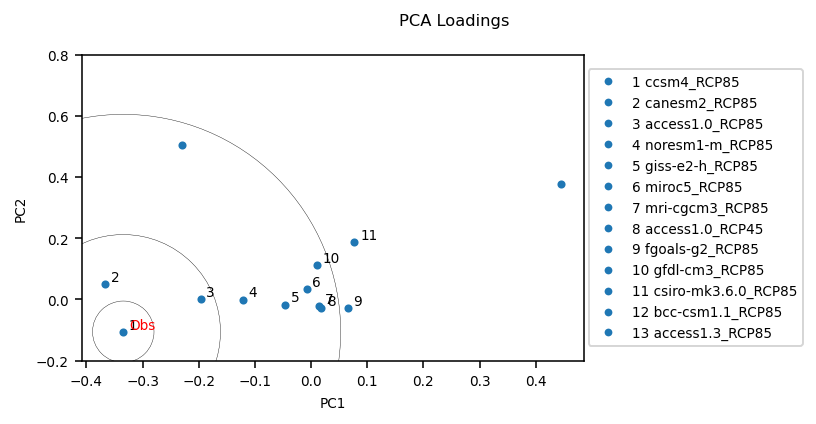

In [29]:
from matplotlib.lines import Line2D

labels = ['{} {}'.format(x, y) for x, y in zip(range(1, len(distances_norm.index)+1), distances_norm.index)]
nums = [x for x in range(1, len(distances_norm.index)+1)]

model_ranking = distances_norm.index.insert(0, 'obs')
loadings = loadings.reindex(model_ranking)

fig, ax = plt.subplots(figsize=(6.5,3))
scatter = ax.scatter(loadings['PC1'], loadings['PC2'], color='tab:blue', s=10)
for i, num in enumerate(nums[:-1]):
    ax.annotate(num, (loadings['PC1'][i]+0.01, loadings['PC2'][i]+0.01))
ax.annotate('Obs', (loadings.loc['obs', 'PC1']+0.01, loadings.loc['obs', 'PC2']+0.01), color='red')

legend_elements = [Line2D([0], [0], marker='o', color='w', label=x, markerfacecolor='tab:blue', markersize=5) for x in labels]

# Concentric circles around observed
ax.scatter(loadings.loc['obs', 'PC1'], loadings.loc['obs', 'PC2'], s=1000, facecolors='none', color='black', linewidth=0.2)
ax.scatter(loadings.loc['obs', 'PC1'], loadings.loc['obs', 'PC2'], s=10000, facecolors='none', color='black', linewidth=0.2)
ax.scatter(loadings.loc['obs', 'PC1'], loadings.loc['obs', 'PC2'], s=50000, facecolors='none', color='black', linewidth=0.2)
ax.set_ylim((-0.2, 0.8))

ax.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.45, 0.5), fancybox=True, ncol=1)
plt.suptitle('PCA Loadings')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
plt.tight_layout()

## Calculating projected metrics of GCMs

Based on Case et al. (2020)

In [30]:
# End of 21st century
end_start = pd.to_datetime('01-01-2070')
end_end = pd.to_datetime('12-31-2099')

proj_temp_end = proj_sims_temp_d[(proj_sims_temp_d.index >= end_start) & (proj_sims_temp_d.index <= end_end)]
proj_ppt_end = proj_sims_ppt_d[(proj_sims_ppt_d.index >= end_start) & (proj_sims_ppt_d.index <= end_end)]

# 30 year normals
hist_start = pd.to_datetime('01-01-1981')
hist_end = pd.to_datetime('12-31-2010')

proj_temp_hist = proj_sims_temp_d[(proj_sims_temp_d.index >= hist_start) & (proj_sims_temp_d.index <= hist_end)]
proj_ppt_hist = proj_sims_ppt_d[(proj_sims_ppt_d.index >= hist_start) & (proj_sims_ppt_d.index <= hist_end)]

obs_t_hist = obs_t[(obs_t.index >= hist_start) & (obs_t.index <= hist_end)]
obs_p_hist = obs_p[(obs_p.index >= hist_start) & (obs_p.index <= hist_end)]


# Projected change in average annual T and average annual precip, 2070-2100 vs 1981-2021 normals
mean_t = proj_temp_end.groupby(pd.Grouper(freq='y')).mean().mean(axis=0)
mean_p = proj_ppt_end.groupby(pd.Grouper(freq='y')).sum().mean(axis=0)

# Deltas from observed normals
hist_t1 = obs_t_hist.groupby(pd.Grouper(freq='y')).mean().mean(0)
hist_p1 = obs_p_hist.groupby(pd.Grouper(freq='y')).sum().mean(0)

delta_t1 = mean_t.values - hist_t1.values
delta_p1 = (mean_p.values - hist_p1.values) / hist_p1.values

# Deltas from GCM normals
hist_t2 = proj_temp_hist.groupby(pd.Grouper(freq='y')).mean().mean(0)
hist_p2 = proj_ppt_hist.groupby(pd.Grouper(freq='y')).sum().mean(0)

delta_t2 = mean_t.values - hist_t2.values
delta_p2 = (mean_p.values - hist_p2.values) / hist_p2.values

# # Get monthly means
# monthly_t = proj_temp_sub.groupby(pd.Grouper(freq='m')).mean()
# monthly_obs_t = obs_t.groupby(pd.Grouper(freq='m')).mean()
# monthly_p = proj_ppt_sub.groupby(pd.Grouper(freq='m')).mean()
# monthly_obs_p = obs_p.groupby(pd.Grouper(freq='m')).mean()


# # Yearly mean temp/precip
# mean_t = monthly_t.groupby(pd.Grouper(freq='y')).mean().mean(axis=0)  # deg C
# mean_obs_t = monthly_obs_t.groupby(pd.Grouper(freq='y')).mean().mean(axis=0)
# mean_p = monthly_p.groupby(pd.Grouper(freq='y')).sum().mean(axis=0)  # mm/yr
# mean_obs_p = monthly_obs_p.groupby(pd.Grouper(freq='y')).sum().mean(axis=0)

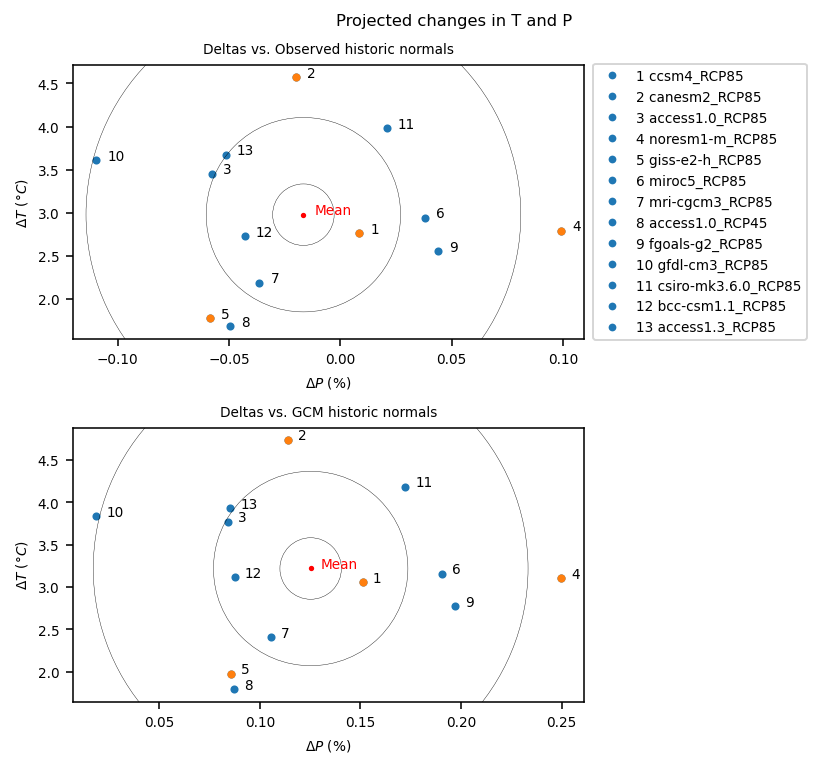

In [31]:
# ========================================================
# Deltas vs Observed historical normals

deltas = pd.DataFrame(np.column_stack([delta_t1, delta_p1, delta_t2, delta_p2]),
                      columns=['delta_t1', 'delta_p1', 'delta_t2', 'delta_p2'], 
                      index=proj_temp_end.columns)
deltas = deltas.reindex(distances_norm.index)

labels = ['{} {}'.format(x, y) for x, y in zip(range(1, len(distances_norm.index)+1), distances_norm.index)]
nums = [x for x in range(1, len(distances_norm.index)+1)]

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(6.5, 5.5))
scatter = axes[0].scatter(deltas['delta_p1'], deltas['delta_t1'], color='tab:blue', s=10)
scatter = axes[1].scatter(deltas['delta_p2'], deltas['delta_t2'], color='tab:blue', s=10)

for i, num in enumerate(nums):
    axes[0].annotate(num, (deltas['delta_p1'][i]+0.005, deltas['delta_t1'][i]+0.005))
    axes[1].annotate(num, (deltas['delta_p2'][i]+0.005, deltas['delta_t2'][i]+0.005))

legend_elements = [Line2D([0], [0], marker='o', color='w', label=x, markerfacecolor='tab:blue', markersize=5) for x in labels]

# Concentric circles around mean
avg_t, avg_p = np.mean(delta_t1), np.mean(delta_p1)
axes[0].scatter(avg_p, avg_t, s=1000, facecolors='none', color='black', linewidth=0.2)
axes[0].scatter(avg_p, avg_t, s=10000, facecolors='none', color='black', linewidth=0.2)
axes[0].scatter(avg_p, avg_t, s=50000, facecolors='none', color='black', linewidth=0.2)
axes[0].scatter(avg_p, avg_t, color='red', s=3)
axes[0].annotate('Mean', (avg_p+0.005, avg_t+0.005), color='red')

avg_t, avg_p = np.mean(delta_t2), np.mean(delta_p2)
axes[1].scatter(avg_p, avg_t, s=1000, facecolors='none', color='black', linewidth=0.2)
axes[1].scatter(avg_p, avg_t, s=10000, facecolors='none', color='black', linewidth=0.2)
axes[1].scatter(avg_p, avg_t, s=50000, facecolors='none', color='black', linewidth=0.2)
axes[1].scatter(avg_p, avg_t, color='red', s=3)
axes[1].annotate('Mean', (avg_p+0.005, avg_t+0.005), color='red')

# Highlight selected models
selected_models = [5,2,4,1]
model_types = ['warm', 'hot', 'hot+wet', 'mean']
for model in selected_models:
    axes[0].scatter(deltas.iloc[model-1, 1], deltas.iloc[model-1, 0], s=10, color='tab:orange')
    axes[1].scatter(deltas.iloc[model-1, 3], deltas.iloc[model-1, 2], s=10, color='tab:orange')

axes[0].legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.45, 0.5), fancybox=True, ncol=1)
plt.suptitle('Projected changes in T and P')
axes[0].set_title('Deltas vs. Observed historic normals')
axes[1].set_title('Deltas vs. GCM historic normals')
axes[0].set_ylabel(r'$\Delta T$ $(\degree C)$')
axes[0].set_xlabel(r'$\Delta P$ $(\%)$')
axes[1].set_ylabel(r'$\Delta T$ $(\degree C)$')
axes[1].set_xlabel(r'$\Delta P$ $(\%)$')
plt.tight_layout()

## Final selected GCMs

In [32]:
# Selected models
names = [deltas.iloc[model-1, :].name for model in selected_models]
names_edit = [y.replace('-', '_') for y in [x.replace('.', '_') for x in names]]
for name, mtype in zip(names_edit, model_types):
    print('{} ({})'.format(name, mtype))

giss_e2_h_RCP85 (warm)
canesm2_RCP85 (hot)
noresm1_m_RCP85 (hot+wet)
ccsm4_RCP85 (mean)


## Export temp and precip of all GCMs

In [ ]:
# # Export precip

# sim_start = pd.to_datetime('01-01-2020')
# sim_end = pd.to_datetime('12-31-2099')

# wrf_dir = config.data_path / 'precip' / 'VIC_WRF_EllsworthCr'
# wrf_file = 'flux_46.40625_-123.90625'
# wrf_cols = ["YEAR","MONTH","DAY","HOUR","OUT_PREC","OUT_PET_SHORT",
#             "OUT_SWE","OUT_EVAP","OUT_RUNOFF","OUT_BASEFLOW",
#             "OUT_SOIL_MOIST0", "OUT_SOIL_MOIST1","OUT_SOIL_MOIST2"]

# sims = ['access1.0_RCP45', 'access1.0_RCP85', 'access1.3_RCP85', 'bcc-csm1.1_RCP85', 
#         'canesm2_RCP85', 'ccsm4_RCP85', 'csiro-mk3.6.0_RCP85', 'fgoals-g2_RCP85', 
#         'gfdl-cm3_RCP85', 'giss-e2-h_RCP85', 'miroc5_RCP85', 'mri-cgcm3_RCP85', 'noresm1-m_RCP85']

# # Valid file names
# sim_names = [y.replace('-', '_') for y in [x.replace('.', '_') for x in sims]]

# for i, sim in enumerate(sims):
#     outfile_ppt = config.velma_data / 'precip' / '{}_20_99_ppt.csv'.format(sim_names[i])
#     arr = np.loadtxt(wrf_dir / sim / 'sim_avg' / wrf_file)
#     df = pd.DataFrame(arr, columns=wrf_cols)
#     df.index = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
#     daily_ppt = df.groupby(pd.Grouper(freq='d')).sum()['OUT_PREC']
#     daily_ppt_sim = daily_ppt[(daily_ppt.index >= sim_start) & (daily_ppt.index <= sim_end)]
#     daily_ppt_sim.to_csv(outfile_ppt, header=False, index=False)

In [ ]:
# # Export temp

# sim_start = pd.to_datetime('01-01-2020')
# sim_end = pd.to_datetime('12-31-2099')

# forc_dir = config.data_path / 'precip' / 'WRF_frcs_EllsworthCr_forcings'
# forc_file = 'forc_46.40625_-123.90625'
# forc_cols = ['Year', 'Month', 'Day', 'Hour', 'Precip(mm)', 'Temp(C)', 
#              'Wind(m/s)', 'SWrad(W/m2)', 'LWrad(W/m2)', 'pressure(kPa)', 
#              'VaporPress(kPa)']

# sims = ['access1.0_RCP45', 'access1.0_RCP85', 'access1.3_RCP85', 'bcc-csm1.1_RCP85', 
#         'canesm2_RCP85', 'ccsm4_RCP85', 'csiro-mk3.6.0_RCP85', 'fgoals-g2_RCP85', 
#         'gfdl-cm3_RCP85', 'giss-e2-h_RCP85', 'miroc5_RCP85', 'mri-cgcm3_RCP85', 'noresm1-m_RCP85']

# # Valid file names
# sim_names = [y.replace('-', '_') for y in [x.replace('.', '_') for x in sims]]

# for i, sim in enumerate(sims):
#     outfile_temp = config.velma_data / 'temp' / '{}_20_99_temp.csv'.format(sim_names[i])
#     arr = np.loadtxt(forc_dir / sim / forc_file)
#     df = pd.DataFrame(arr, columns=forc_cols)
#     df.index = pd.to_datetime(df[['Year', 'Month', 'Day']])
#     daily_temp = df.groupby(pd.Grouper(freq='d')).mean()['Temp(C)']
#     daily_temp_sim = daily_temp[(daily_temp.index >= sim_start) & (daily_temp.index <= sim_end)]
#     daily_temp_sim.to_csv(outfile_temp, header=False, index=False)